In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import classification_report

warnings.filterwarnings("ignore", category=DeprecationWarning) 
tf.random.set_seed(221)
np.random.seed(221)

In [2]:
def buildModel(neurons = 32, input_shape = (15,1)):
  model = Sequential()
  model.add(LSTM(neurons, input_shape=input_shape))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def printMetrics(model, x, y, stage):
  scores = model.evaluate(x, y, verbose=0)
  print("(" + stage + ")" + "Erro da LSTM : %.2f%%" % (100-scores[1]*100))
  print("(" + stage + ")" + "Acurária da LSTM  %.2f%%" % (scores[1]*100))
  print("\n")

  if(stage == "treino"):
    print("Matriz de confusão (" + stage + ")")
    y_pred = model.predict(x, verbose = 0)
    y_pred = np.array(np.round(y_pred))
    y = np.array(y)
    cf_matrix = confusion_matrix(y, y_pred)

    print("Precision, recall e f1-score")
    print(classification_report(y, y_pred)) 
    print(cf_matrix[0][0], "Previu COMPRA e era COMPRA")
    print(cf_matrix[0][1], "Previu COMPRA e era VENDA")  
    print(cf_matrix[1][0], "Previu VENDA e era COMPRA")
    print(cf_matrix[1][1], "Previu VENDA e era VENDA")

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    plt.show()

def getData(action, training = False, dropDays=0):
  step = "treino" if training else "teste"
  df = pd.read_csv("./" + action + "./" + step + ".csv")
  df.drop(columns=["Unnamed: 0", "Smoothed_Close", "Close", "Date"], inplace=True)

  if(dropDays > 0):
    columns_to_drop = []
    for day in reversed(range(dropDays)):
      columns_to_drop.append("Past_" + str(15-day)+ "_Days_Close")
    df.drop(columns=columns_to_drop, inplace=True)

  x = df.drop(columns=["Label"])
  y = df["Label"]

  scaler = MinMaxScaler(feature_range=(0, 1))
  x = scaler.fit_transform(x)
  y = y.replace(-1, 0)
  
  x = np.reshape(x, (x.shape[0], x.shape[1], 1))
  return x, y

In [3]:
action = "BBAS3.SA"
x_train, y_train = getData(action=action, training=True)
x_test, y_test = getData(action=action, training=False)
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(4735, 15, 1)
(4735,)
(1185, 15, 1)
(1185,)


In [4]:
model = buildModel()
history = model.fit(x_train, y_train, validation_split = 0.2, epochs=100, batch_size=10, verbose=0)
printMetrics(model, x_train, y_train, "TREINO")
printMetrics(model, x_test, y_test, "TESTE")





(TREINO)Erro da LSTM : 24.54%
(TREINO)Acurária da LSTM  75.46%


(TESTE)Erro da LSTM : 27.17%
(TESTE)Acurária da LSTM  72.83%




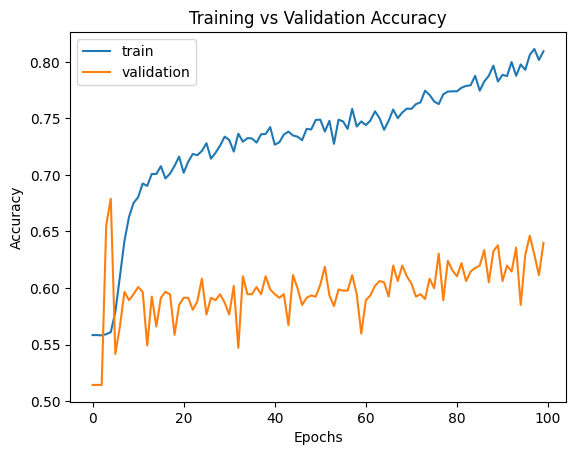

In [5]:
plt.figure(1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "validation"], loc='upper left')
plt.show()

In [ ]:
actions = ["BBAS3.SA", "CSNA3.SA", "PETR4.SA", "VALE3.SA"]
for action in actions:
  x_train, y_train = getData(action=action, training=True)
  x_test, y_test = getData(action=action, training=False)

  model = buildModel()
  print("Treinando modelo para a ação:", action)
  
  # A acuracia de validação dessa ação em especifico estava BEM distante da acuracia de treino, então pra ela 
  # estou aumentando o tamanho da amostra de validação.
  validation_split = 0.3 if action == "BBAS3.SA" else 0.2
  history = model.fit(x_train, y_train, validation_split = validation_split, epochs=100, batch_size=10, verbose=0)
  printMetrics(model, x_train, y_train, "TREINO")
  printMetrics(model, x_test, y_test, "TESTE")

  print("\n")
  print("--------------------------------------------#################------------------------------------------------------")
  print("\n")
  

In [ ]:
# Testando uma acuracia utilizando uma quantidade menor de t anteriores
# Resultado: Os modelos apresentaram uma acuracia inferior ou igual a quando utilizado os 15 dias

actions = ["BBAS3.SA", "CSNA3.SA", "PETR4.SA", "VALE3.SA"]
for action in actions:
  x_train, y_train = getData(action=action, training=True, dropDays=7)
  x_test, y_test = getData(action=action, training=False, dropDays=7)

  model = buildModel(input_shape=(8, 1))
  history = model.fit(x_train, y_train, validation_split = 0.2, epochs=100, batch_size=10, verbose=0)
  printMetrics(model, x_train, y_train, "TREINO")
  
  print("\n")
  print("--------------------------------------------#################------------------------------------------------------")
  print("\n")